In [1]:
import os
import numpy as np
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

In [2]:
seed_list = [7, 14, 21]
dataset_list = [2, 12, 32, 100]
source_list = [12, 32, 100]
sample_list = [64, 256, 1024, 4096, 16384, 32768]
w_list = ['wpca', 'w0', 'w1']
aux_list = ['aux', 'aux0', 'aux1']
isi_list = ['isi', 'isi0', 'isi1']

datadir = '/Users/xli77/Documents/MISA/MISA-data/torch'

loss = np.zeros([len(dataset_list), len(source_list), len(sample_list), len(seed_list), len(w_list) ])
isi = np.zeros([len(dataset_list), len(source_list), len(sample_list), len(seed_list), len(w_list) ])

for i, n_dataset in enumerate(dataset_list):
    for j, n_source in enumerate(source_list):
        if (n_dataset==32 and n_source==100) or (n_dataset==100 and n_source==32) or (n_dataset==100 and n_source==100):
            continue
        for k, n_sample in enumerate(sample_list):
            if (n_source > n_sample) or (n_sample==64 and n_dataset==100 and n_source==12):
                continue
            for m, w in enumerate(w_list):
                for n, seed in enumerate(seed_list):
                    datapath=os.path.join(datadir, f'out-siva_dataset{n_dataset}_source{n_source}_sample{n_sample}_seed{seed}_{w}')
                    loss[i,j,k,m,n]=float(sio.loadmat(datapath)[aux_list[m]][1,0])
                    isi[i,j,k,m,n]=float(sio.loadmat(datapath)[isi_list[m]])

In [3]:
mean_isi = np.mean(isi,axis=-1) # take mean across random seed
std_isi = np.std(isi,axis=-1) # take std across random seed
lower_bound_isi = mean_isi - std_isi
upper_bound_isi = mean_isi + std_isi

mean_loss = np.mean(loss,axis=-1) # take mean across random seed
std_loss = np.std(loss,axis=-1) # take std across random seed
lower_bound_loss = mean_loss - std_loss
upper_bound_loss = mean_loss + std_loss

In [4]:
isi_pca = isi[-1,0,:,0,:]
isi_median_pca = np.median(isi_pca, axis=1)
ind = isi_median_pca!=0
isi_valid_pca = isi_pca[ind,:]

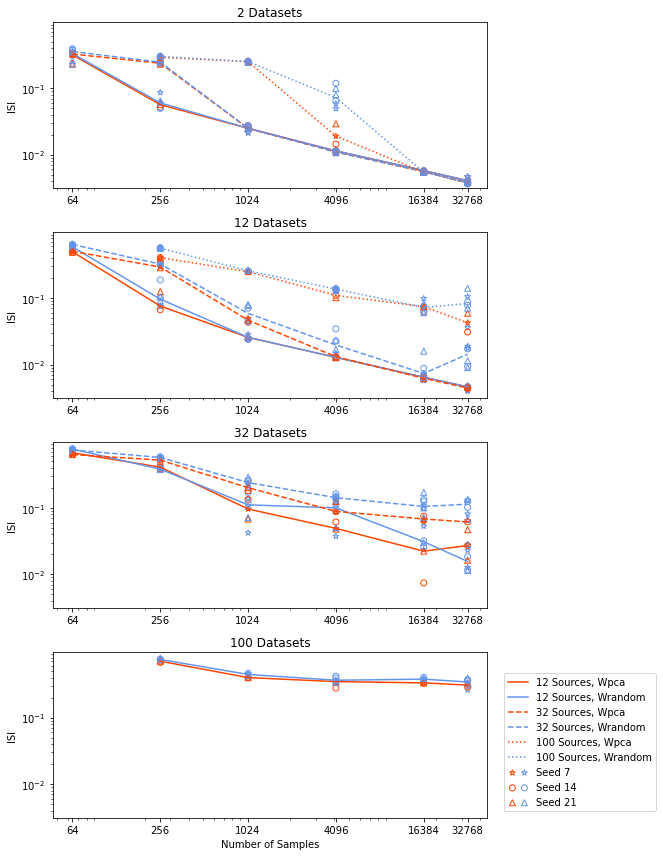

In [5]:
fig, axes = plt.subplots(4,1,figsize=(10,12))
color_list = ['cornflowerblue', 'orangered'] # sns.color_palette('pastel')
linestyle_list = ['solid', 'dashed', 'dotted']
marker_list = ['*', 'o', '^']

for i, m in enumerate(dataset_list):
    p = []
    for j, k in enumerate(source_list):
        isi_pca = isi[i,j,:,0,:]
        isi_rand = np.concatenate([isi[i,j,:,1,:], isi[i,j,:,2,:]], axis=1)
        isi_median_pca = np.median(isi_pca, axis=1)
        isi_median_rand = np.median(isi_rand, axis=1)

        ind = isi_median_pca!=0
        isi_valid_pca = isi_pca[ind,:]
        isi_valid_rand = isi_rand[ind,:]
        isi_median_valid_pca = isi_median_pca[ind]
        isi_median_valid_rand = isi_median_rand[ind]
        sample_arr = np.asarray(sample_list) 
        sample_arr_valid = sample_arr[ind]

        p1, = axes[i].plot(sample_arr_valid, isi_median_valid_pca, linestyle=linestyle_list[j], color=color_list[1], label=f'{k} Sources, Wpca') # Wpca
        p2, = axes[i].plot(sample_arr_valid, isi_median_valid_rand, linestyle=linestyle_list[j], color=color_list[0], label=f'{k} Sources, Wrandom') # Wrandom

        p.append(p1)
        p.append(p2)

        for l, s in enumerate(seed_list):
            if j==2:
                p3 = axes[i].scatter(sample_arr_valid, isi_valid_pca[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[1], label=f'Seed {s}')
                p4 = axes[i].scatter(sample_arr_valid, isi_valid_rand[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[0], label=f'Seed {s}')
                axes[i].scatter(sample_arr_valid, isi_valid_rand[:,l+3], marker=marker_list[l], facecolors='none', edgecolors=color_list[0])
                p.append((p3, p4))
            else:
                axes[i].scatter(sample_arr_valid, isi_valid_pca[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[1])
                axes[i].scatter(sample_arr_valid, isi_valid_rand[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[0])
                axes[i].scatter(sample_arr_valid, isi_valid_rand[:,l+3], marker=marker_list[l], facecolors='none', edgecolors=color_list[0])

        axes[i].set_xscale('log')
        axes[i].set_yscale('log')
        axes[i].set_xticks(sample_list)
        axes[i].set_xticklabels(sample_list)
        axes[i].set_title(f"{m} Datasets")
        axes[i].set_ylabel("ISI")

axes[-1].set_xlabel("Number of Samples")

axes[-1].legend(p, ['12 Sources, Wpca', '12 Sources, Wrandom', '32 Sources, Wpca', '32 Sources, Wrandom',
    '100 Sources, Wpca', '100 Sources, Wrandom', 'Seed 7', 'Seed 14', 'Seed 21'],
    scatterpoints=1, numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)}, bbox_to_anchor=(1.4, 0.9))

# for i in range(len(dataset_list)):
#     print(axes[i].get_ylim())

xlim = axes[1].get_xlim()
ylim = (axes[1].get_ylim()[0], axes[2].get_ylim()[1])

for i in range(len(dataset_list)):
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)

plt.tight_layout()
plt.savefig("/Users/xli77/Documents/MISA-pytorch/figures/ISI_dataset.pdf", dpi=300)

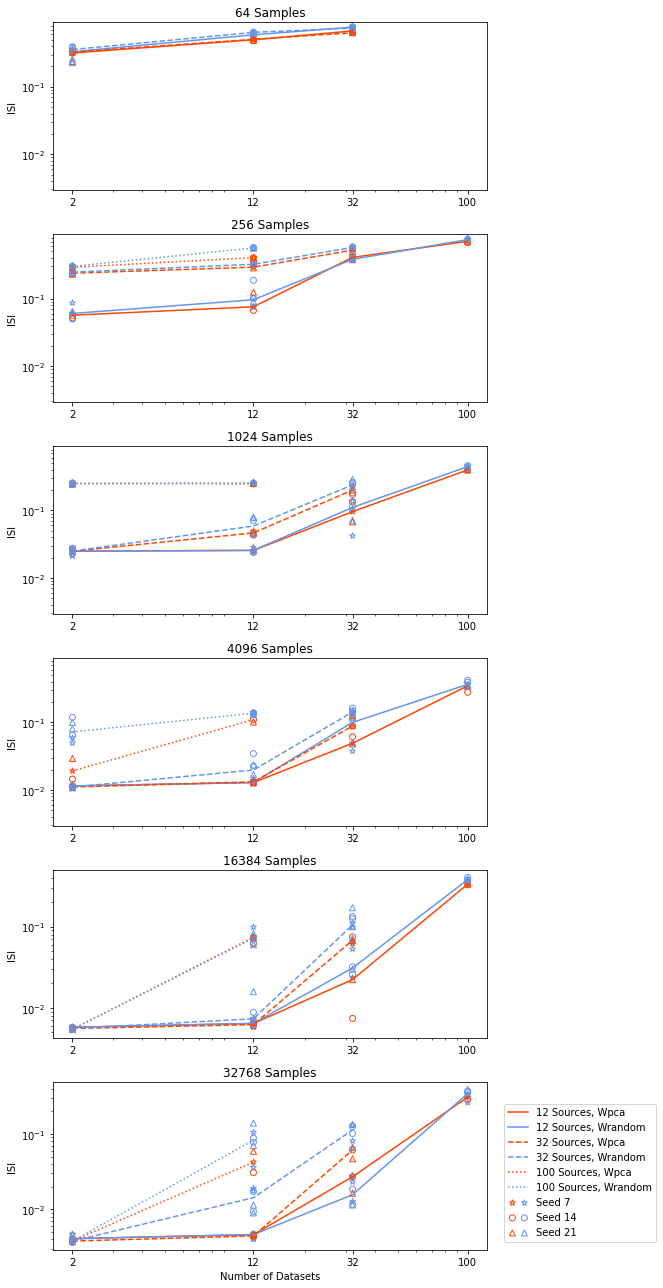

In [6]:
fig, axes = plt.subplots(len(sample_list),1,figsize=(10,3*len(sample_list)))
color_list = ['cornflowerblue', 'orangered'] # sns.color_palette('pastel')
linestyle_list = ['solid', 'dashed', 'dotted']
marker_list = ['*', 'o', '^']

for i, m in enumerate(sample_list):
    p = []
    for j, k in enumerate(source_list):
        isi_pca = isi[:,j,i,0,:]
        isi_rand = np.concatenate([isi[:,j,i,1,:], isi[:,j,i,2,:]], axis=1)
        isi_median_pca = np.median(isi_pca, axis=1)
        isi_median_rand = np.median(isi_rand, axis=1)

        ind = isi_median_pca!=0
        isi_valid_pca = isi_pca[ind,:]
        isi_valid_rand = isi_rand[ind,:]
        isi_median_valid_pca = isi_median_pca[ind]
        isi_median_valid_rand = isi_median_rand[ind]
        sample_arr = np.asarray(dataset_list) 
        sample_arr_valid = sample_arr[ind]

        p1, = axes[i].plot(sample_arr_valid, isi_median_valid_pca, linestyle=linestyle_list[j], color=color_list[1], label=f'{k} Sources, Wpca') # Wpca
        p2, = axes[i].plot(sample_arr_valid, isi_median_valid_rand, linestyle=linestyle_list[j], color=color_list[0], label=f'{k} Sources, Wrandom') # Wrandom

        p.append(p1)
        p.append(p2)

        for l, s in enumerate(seed_list):
            if j==2:
                p3 = axes[i].scatter(sample_arr_valid, isi_valid_pca[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[1], label=f'Seed {s}')
                p4 = axes[i].scatter(sample_arr_valid, isi_valid_rand[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[0], label=f'Seed {s}')
                axes[i].scatter(sample_arr_valid, isi_valid_rand[:,l+3], marker=marker_list[l], facecolors='none', edgecolors=color_list[0])
                p.append((p3, p4))
            else:
                axes[i].scatter(sample_arr_valid, isi_valid_pca[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[1])
                axes[i].scatter(sample_arr_valid, isi_valid_rand[:,l], marker=marker_list[l], facecolors='none', edgecolors=color_list[0])
                axes[i].scatter(sample_arr_valid, isi_valid_rand[:,l+3], marker=marker_list[l], facecolors='none', edgecolors=color_list[0])

        axes[i].set_xscale('log')
        axes[i].set_yscale('log')
        axes[i].set_xticks(dataset_list)
        axes[i].set_xticklabels(dataset_list)
        axes[i].set_title(f"{m} Samples")
        axes[i].set_ylabel("ISI")

axes[-1].set_xlabel("Number of Datasets")

axes[-1].legend(p, ['12 Sources, Wpca', '12 Sources, Wrandom', '32 Sources, Wpca', '32 Sources, Wrandom',
    '100 Sources, Wpca', '100 Sources, Wrandom', 'Seed 7', 'Seed 14', 'Seed 21'],
    scatterpoints=1, numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)}, bbox_to_anchor=(1.4, 0.9))

# for i in range(len(sample_list)):
#     print(axes[i].get_ylim())

xlim = axes[1].get_xlim()
ylim = (axes[-1].get_ylim()[0], axes[1].get_ylim()[1])

for i in range(len(sample_list)):
    axes[i].set_xlim(xlim)
    axes[i].set_ylim(ylim)

plt.tight_layout()
plt.savefig("/Users/xli77/Documents/MISA-pytorch/figures/ISI_sample.pdf", dpi=300)